# DS13_Assignment

## By Saeideh Pourghasemian

Create a synthetic data set with 1000 observations and two variables (x, y)

The underlying stochastic process is :

       y = 3.5 + 1.8 * x - 0.15 * x ^ 2 - 0.08 * x ^ 3 + Noise

       0 <= x <= 5

       Noise ~ N(0, 0.8)

       set.seed(1234)

       Create a dataframe to contain both x and y .

-- a) Split data into test and train.

       Perform forward selection, backward elimination. and LASSO in order to choose the best model containing the predictors x, x ^ 2, ..., x ^ 10.

       What are the best models obtained according to AIC, BIC, adjusted R, and k-fold cross validation (for LASSO).

       Show some plots to provide evidence for your answer, and report the coefficients of the best models obtained.
--b) Apply the best models on test data set.

       Evaluate the performance of your models on test.

       Plot actual (y) vs. prediction (y_hat).

       Visualize the real relation btw x and y vs. estimated ones.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
#Create a synthetic data set
np.random.seed(1234)
x = np.linspace(0, 5, 1000)
y = 3.5 + (1.8 * x) - (0.15 * x ** 2) - (0.08 * x ** 3) + np.random.normal(0, .8, 1000)

In [3]:
#Create a dataframe
data = pd.DataFrame({'x' : x,
                     'y' : y})
data.head()

,x,y
0,0.000000,3.877148
1,0.005005,2.556225
2,0.010010,4.664168
3,0.015015,3.276871
4,0.020020,2.959504


In [4]:
#Split data into test and train
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = .3, random_state = 123)
train.sort_values(by = 'x', inplace = True)

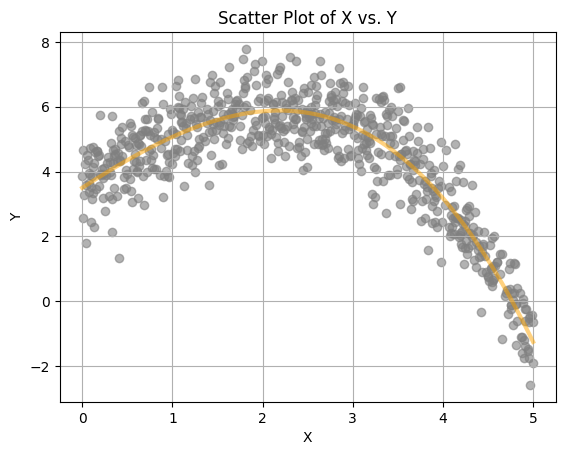

In [5]:
#Plot train data 
plt.scatter(train['x'], train['y'], color = 'gray', alpha = .6)
plt.plot(train['x'], 3.5 + (1.8 * train['x']) - (0.15 * train['x'] ** 2) - (0.08 * train['x'] ** 3), color = 'orange', alpha = .5, linewidth = 3)
plt.title('Scatter Plot of X vs. Y')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

Text(0.5, 1.0, 'y')

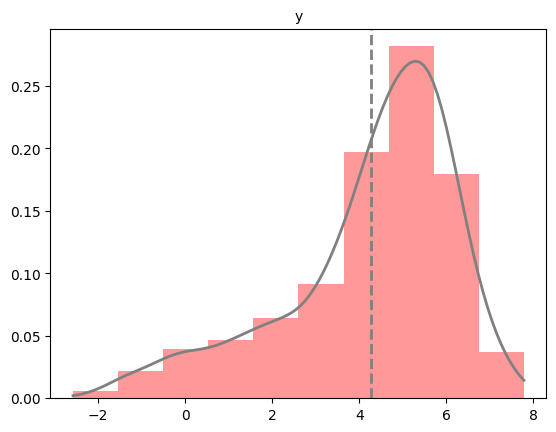

In [6]:
#Histogram of numeric variables
from scipy import stats

plt.hist(x = data.iloc[: , 1], alpha = .4, color = 'red', density = True)
    
plt.axvline(data.iloc[: , 1].mean(), color = 'gray', linewidth = 2, linestyle = '--')
    
density = stats.gaussian_kde(data.iloc[: , 1])
xp = np.linspace(data.iloc[: , 1].min(), data.iloc[: , 1].max(), 100)
yp = density.pdf(xp)
plt.plot(xp, yp, color = 'gray', linewidth = 2)
    
plt.title(data.columns[1], fontsize = 10)

## Data Preparation 

In [7]:
for i in range(2,11):
    column_name = 'x' + str(i)
    train[column_name] = train['x'].apply(lambda _: _ ** i)
    test[column_name]  = test['x'].apply(lambda _: _ ** i)

In [8]:
#Create x_train and y_train
x_train = train.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
x_train = sm.add_constant(x_train) #adding a constant
y_train = train['y']

In [9]:
#Yeo-Johnson transformation
from sklearn.preprocessing import PowerTransformer
yeojohnson = PowerTransformer(method = 'yeo-johnson')
yeojohnson.fit(y_train.values.reshape(-1, 1))
trans_y_train = yeojohnson.fit_transform(y_train.values.reshape(-1, 1))


In [10]:
#BOX-COX transformation
#y_train = y_train + 3
#y_train.tail()

In [11]:
#from sklearn.preprocessing import PowerTransformer
#boxcox = PowerTransformer(method = 'box-cox')
#boxcox.fit(y_train.values.reshape(-1, 1))
#trans_y_train = boxcox.fit_transform(y_train.values.reshape(-1, 1))

In [12]:
#Create x_test and y_test
x_test = test.iloc[:, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
x_test = sm.add_constant(x_test) #adding a constant
y_test = test['y']

## Build Linear Regression Model

### Classic Linear Regression

In [13]:
#Linear regression - model 1
model_1 = sm.OLS(trans_y_train, x_train.iloc[:, [0, 1, 3]]).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     923.8
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.01e-196
Time:                        23:28:04   Log-Likelihood:                -540.02
No. Observations:                 700   AIC:                             1086.
Df Residuals:                     697   BIC:                             1100.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3742      0.052     -7.209      0.000      -0.476      -0.272
x              0.7562      0.034     22.492      0.000       0.690       0.822
x3            -0.0496      0.001    -35.616      0.000      -0.052      -0.047
==============================================================================
Omnibus:                        8.136   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                8.128
Skew:                           0.262   Prob(JB):                       0.0172
Kurtosis:                       3.057   Cond. No.                         139.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
#Function to plot histogram of residuals
def hist_residuals(model, bins = 50):
    #Calculate density
    from scipy import stats
    density = stats.gaussian_kde(model.resid)
    xp = np.linspace(model.resid.min(), model.resid.max(), 100)
    yp = density.pdf(xp)

    #Histogram
    plt.hist(model.resid, bins = bins, 
             color = 'red', alpha = .6, density = True)
    plt.axvline(model.resid.mean(), color = 'gray', 
                linewidth = 2, linestyle = '--', label = "Average")
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Density')
    plt.plot(xp, yp, color = 'gray', linewidth = 2)
    plt.legend()
    
    return plt.show()  

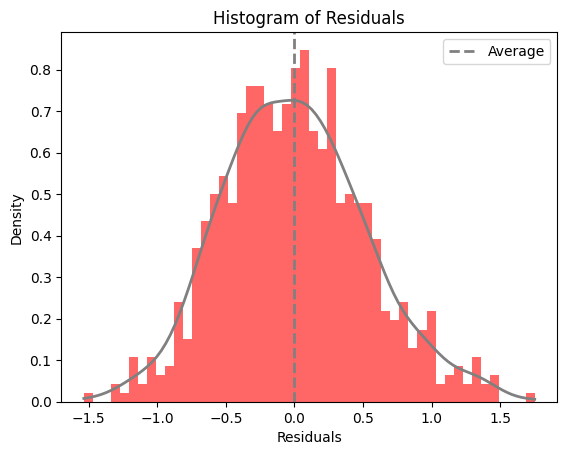

In [15]:
#Histogram of residuals - model 1
hist_residuals(model_1)

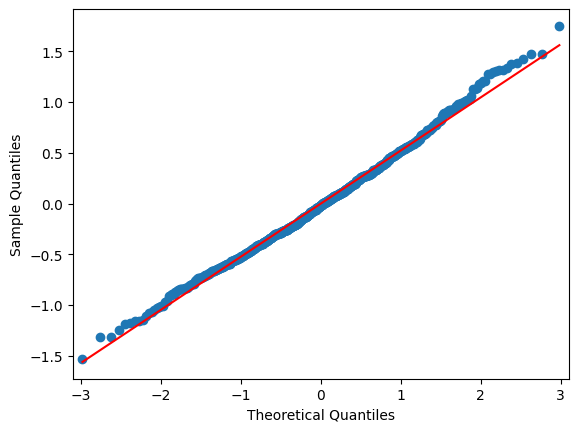

In [16]:
#QQ-plot - model 1
sm.qqplot(model_1.resid, line = 's')
plt.show()

In [17]:
#Function to plot residuals vs. fitted values
def residuals_fittedvalues_plot(model):
    #Implement Lowess algorithm
    lowess_res = sm.nonparametric.lowess(model.resid, model.fittedvalues)

    #Scatter plot: residuals vs. fitted values
    plt.scatter(x = model.fittedvalues, y = model.resid, 
                color = 'red', alpha = .6, label = 'data')
    plt.title('Residuals vs. Fitted values')
    plt.xlabel('Fitted Values', fontsize = 12)
    plt.ylabel('Residuals', fontsize = 12)
    plt.grid()

    #Add LOWESS line
    plt.plot(lowess_res[:, 0], lowess_res[:, 1], 'gray', 
             alpha = 0.8, linewidth = 2, label = 'LOWESS')
    plt.legend()

    #Top three observations with greates absolute value of the residual
    top3 = abs(model.resid).sort_values(ascending = False)[:3]
    for i in top3.index:
        plt.annotate(i, xy = (model.fittedvalues[i], model.resid[i]), color = 'blue')
    
    return plt.show()

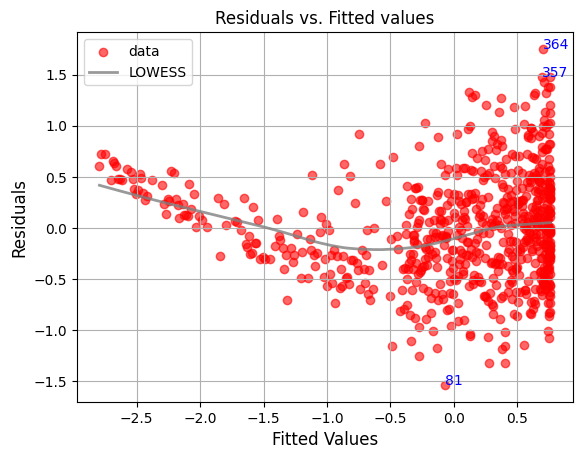

In [18]:
#Scatter plot of residuals vs. fitted values - model 1
residuals_fittedvalues_plot(model_1)

In [19]:
#Function to check Cook's distance
def influencer_detector(model, thershold = 1):
    
    #create instance of influence
    influence = model.get_influence()

    #Obtain Cook's distance for each observation
    cooks = influence.cooks_distance

    #Check observations w/ Cook's distance greater than thershold
    return np.where(cooks[0] > 1)

In [20]:
#Check Cook's ditance - model 1
influencer_detector(model_1)

(array([], dtype=int64),)

In [21]:
#Function to check multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):
    #Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return(vif)

In [22]:
#Check multicollinearity for numeric variables
calc_vif(x_train.iloc[:,[0, 1, 3]])
#Note: If VIF > 10 then multicollinearity is high

,variables,VIF
0,const,6.857034
1,x,5.858783
2,x3,5.858783


In [23]:
#Prediction using model 1
pred_lm = model_1.predict(x_test.iloc[:, [0, 1, 3]])
pred_lm = pd.Series(yeojohnson.inverse_transform(pred_lm.values.reshape(-1, 1)).reshape(-1), index = test.index)
#pred_lm = pred_lm - 3

In [24]:
#Absolute error
abs_err_lm = abs(test['y'] - pred_lm)

from scipy.stats import iqr

#Absolute error mean, median, sd, IQR, max, min
models_comp = pd.DataFrame({'Mean of AbsErrors':    abs_err_lm.mean(),
                            'Median of AbsErrors':  abs_err_lm.median(),
                            'SD of AbsErrors' :     abs_err_lm.std(),
                            'IQR of AbsErrors':     iqr(abs_err_lm),
                            'Min of AbsErrors':     abs_err_lm.min(),
                            'Max of AbsErrors':     abs_err_lm.max()}, 
                            index = ['LM_t-test'])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
LM_t-test,0.994962,0.561788,1.888351,0.752861,0.000062,16.660633


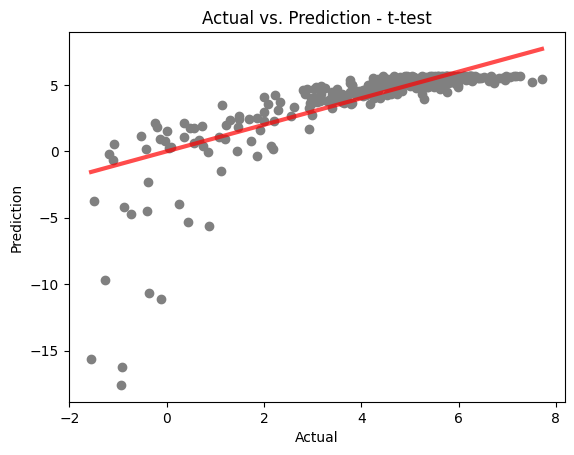

In [25]:
#Actual vs. Prediction
plt.scatter(x = test['y'], y = pred_lm, c = 'gray')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - t-test')

#Add 45 degree line
xp = np.linspace(test['y'].min(), test['y'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .7)
plt.show()

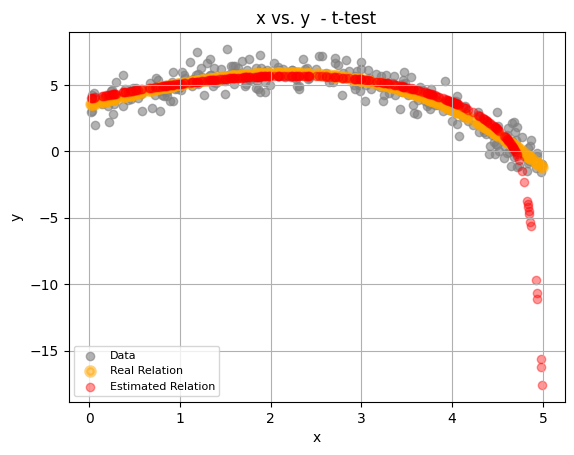

In [26]:
#Real relation btw x and y vs. estimated ones
plt.scatter(test['x'], test['y'], c = 'gray', alpha = .6, label = 'Data')
plt.scatter(test['x'], 3.5 + (1.8 * test['x']) - (0.15 * test['x'] ** 2) - (0.08 * test['x'] ** 3), c = 'orange', linewidth = 3,
         alpha = .5, label = 'Real Relation')
plt.scatter(test['x'], pred_lm, c = 'red', alpha = .4, label = 'Estimated Relation')
plt.title('x vs. y  - t-test')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = '8')
plt.grid()

### Forward Selection

In [27]:
#Define function to fit linear regression
def fit_lm(feature_set, y, X):
    reg_model = sm.OLS(y, X[['const'] + list(feature_set)]).fit()
    return {'model': reg_model, 
            'r2': reg_model.rsquared,
            'adj_r2': reg_model.rsquared_adj,
            'aic': reg_model.aic,
            'bic': reg_model.bic}

In [28]:
#Define function to do forward selection
def fwd_selection(features, y, X):
    res = []
    #Pull out features still needed to process
    remaining_features = [_ for _ in X.iloc[:, 1:].columns if _ not in features]
          
    #Fit linear model and save the results
    for f in remaining_features:
        res.append(fit_lm(features + [f], y, X))
   
    models = pd.DataFrame(res)
    
    #Choose the model with the highest R squared
    best_model = models.iloc[models['r2'].argmax()] 
    
    #Return the best model
    return best_model

In [29]:
#Forward selection implementation
import time #to measure the processing time
fwd_models = pd.DataFrame(columns = ['model', 'r2', 'adj_r2', 'aic', 'bic'])
start_time = time.time()
features = []
for i in range(1, len(x_train.iloc[:, 1:].columns) + 1):
    fwd_models.loc[i] = fwd_selection(features, trans_y_train, x_train)
    features = fwd_models.loc[i, 'model'].model.exog_names[1:]
end_time = time.time()
print('The Processing time is: ', end_time - start_time, 'seconds')

The Processing time is:  0.05787301063537598 seconds


In [30]:
fwd_models

,model,r2,adj_r2,aic,bic
1,<statsmodels.regression.linear_model.Regressio...,0.594102,0.593521,1359.356506,1368.458667
2,<statsmodels.regression.linear_model.Regressio...,0.655889,0.654901,1245.760928,1259.414169
3,<statsmodels.regression.linear_model.Regressio...,0.75096,0.749886,1021.415767,1039.620088
4,<statsmodels.regression.linear_model.Regressio...,0.751085,0.749653,1023.062134,1045.817535
5,<statsmodels.regression.linear_model.Regressio...,0.751764,0.749976,1023.150505,1050.456987
6,<statsmodels.regression.linear_model.Regressio...,0.751881,0.749732,1024.821991,1056.679553
7,<statsmodels.regression.linear_model.Regressio...,0.752274,0.749768,1025.711359,1062.120002
8,<statsmodels.regression.linear_model.Regressio...,0.752769,0.749907,1026.310562,1067.270285
9,<statsmodels.regression.linear_model.Regressio...,0.752779,0.749555,1028.282572,1073.793375
10,<statsmodels.regression.linear_model.Regressio...,0.753106,0.749522,1029.357102,1079.418986


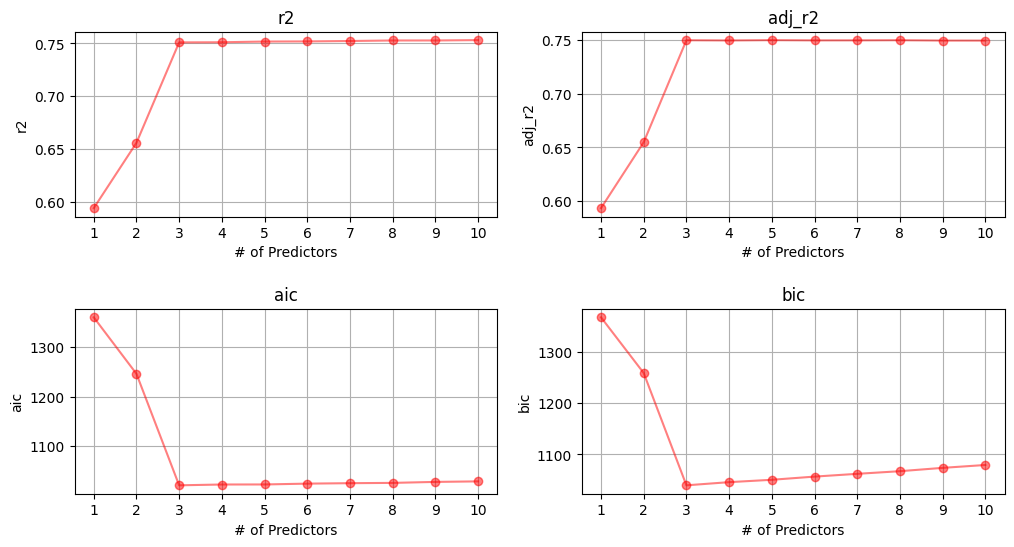

In [31]:
#Models evaluation
plt.figure(figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.plot(fwd_models.iloc[:, i], 'r-o', alpha = 0.5)
    plt.title(fwd_models.columns[i])
    plt.xlabel('# of Predictors')
    plt.xticks(range(1, 11))
    plt.ylabel(fwd_models.columns[i])
    plt.grid()    

In [32]:
#Liner model with 3 Variables (based on adjusted aic)
fwd_models.loc[3, 'model'].params

const   -0.542440
x5       0.005375
x        0.928562
x4      -0.036899
dtype: float64

In [33]:
#Selected features 
fwd_models.loc[3, 'model'].model.exog_names

['const', 'x5', 'x', 'x4']

In [34]:
#Predict on test - model 2
pred_fwd = fwd_models.loc[3, 'model'].predict(x_test[fwd_models.loc[3, 'model'].model.exog_names])
pred_fwd = pd.Series(yeojohnson.inverse_transform(pred_fwd.values.reshape(-1, 1)).reshape(-1), index = test.index)


In [35]:
#Absolute error
abs_err_fwd = abs(test['y'] - pred_fwd)

#Absolute error mean, median, sd, IQR, max, min
models_comp = pd.concat([models_comp, 
              pd.DataFrame({'Mean of AbsErrors':    abs_err_fwd.mean(),
                            'Median of AbsErrors':  abs_err_fwd.median(),
                            'SD of AbsErrors' :     abs_err_fwd.std(),
                            'IQR of AbsErrors':     iqr(abs_err_fwd),
                            'Min of AbsErrors':     abs_err_fwd.min(),
                            'Max of AbsErrors':     abs_err_fwd.max()}, 
                            index = ['LM_FWD'])])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
LM_t-test,0.994962,0.561788,1.888351,0.752861,0.000062,16.660633
LM_FWD,0.610102,0.479101,0.486081,0.645161,0.001382,2.168739


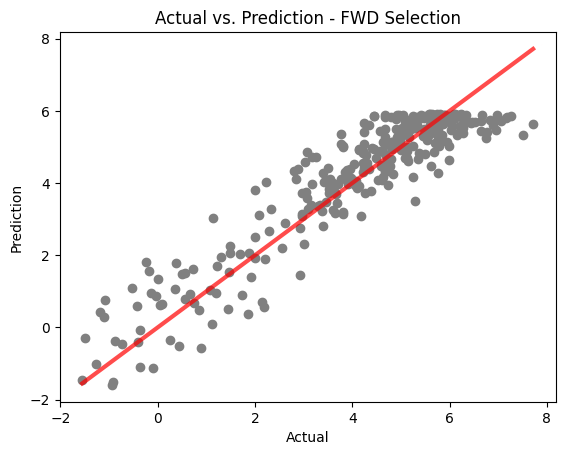

In [36]:
#Actual vs. Prediction
plt.scatter(x = test['y'], y = pred_fwd, c = 'gray')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - FWD Selection')

#Add 45 degree line
xp = np.linspace(test['y'].min(), test['y'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .7)
plt.show()

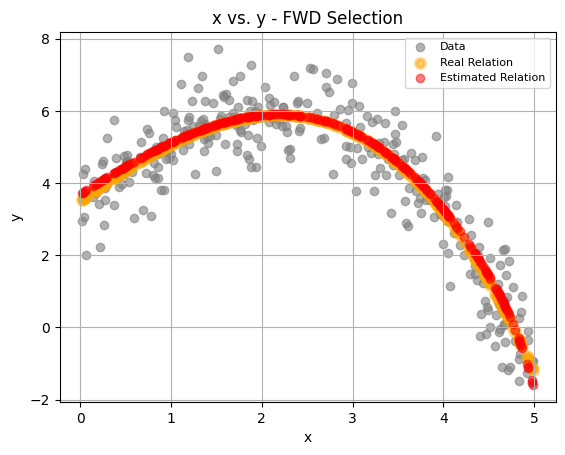

In [37]:
#Real relation btw x and y vs. estimated ones
plt.scatter(test['x'], test['y'], c = 'gray', alpha = .6, label = 'Data')
plt.scatter(test['x'], 3.5 + (1.8 * test['x']) - (0.15 * test['x'] ** 2) - (0.08 * test['x'] ** 3), c = 'orange', linewidth = 3,
         alpha = .5, label = 'Real Relation')
plt.scatter(test['x'], pred_fwd, c = 'red', alpha = .5, label = 'Estimated Relation')
plt.title('x vs. y - FWD Selection')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = '8')
plt.grid()

### Backward Elimination

In [38]:
#Define function to do backward elimination
def bwd_elimination(features, y, X):
    res = []
    
    #Fit linear model and save the results
    for f in itertools.combinations(features, len(features) - 1):
        res.append(fit_lm(f, y, X))
    
    models = pd.DataFrame(res)
    
    #Choose the model with the highest R squared
    best_model = models.iloc[models['r2'].argmax()] 
          
    #Return the best model
    return best_model

In [39]:
#Backward elimination implementation
import itertools
bwd_models = pd.DataFrame(columns = ['model', 'r2', 'adj_r2', 'aic', 'bic'])
start_time = time.time()
features = x_train.columns
while(len(features) > 1):  
    bwd_models.loc[len(features) - 1] = bwd_elimination(features, trans_y_train, x_train)
    features = bwd_models.loc[len(features) - 1]['model'].model.exog_names[1:]
end_time = time.time()
print('The Processing time is: ', end_time - start_time, 'seconds')

The Processing time is:  0.071807861328125 seconds


In [40]:
bwd_models

,model,r2,adj_r2,aic,bic
10,<statsmodels.regression.linear_model.Regressio...,0.753106,0.749522,1029.357102,1079.418986
9,<statsmodels.regression.linear_model.Regressio...,0.7531,0.74988,1027.372223,1072.883026
8,<statsmodels.regression.linear_model.Regressio...,0.752634,0.74977,1026.694262,1067.653985
7,<statsmodels.regression.linear_model.Regressio...,0.752374,0.749869,1025.429961,1061.838604
6,<statsmodels.regression.linear_model.Regressio...,0.752367,0.750223,1023.449809,1055.307371
5,<statsmodels.regression.linear_model.Regressio...,0.750094,0.748294,1027.844431,1055.150913
4,<statsmodels.regression.linear_model.Regressio...,0.746265,0.744805,1036.488903,1059.244305
3,<statsmodels.regression.linear_model.Regressio...,0.744451,0.74335,1039.474782,1057.679104
2,<statsmodels.regression.linear_model.Regressio...,0.687253,0.686355,1178.862072,1192.515313
1,<statsmodels.regression.linear_model.Regressio...,0.527276,0.526598,1466.04414,1475.1463


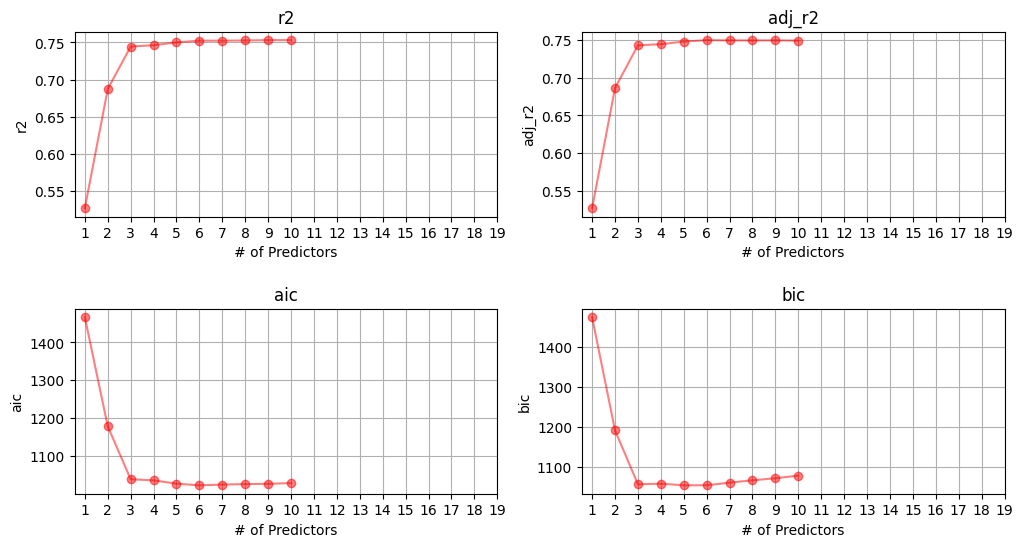

In [41]:
#Models evaluation
plt.figure(figsize = (12, 6))
plt.subplots_adjust(hspace = 0.5, wspace = 0.2)
for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.plot(bwd_models.iloc[:, i], 'r-o', alpha = 0.5)
    plt.title(bwd_models.columns[i])
    plt.xlabel('# of Predictors')
    plt.xticks(range(1, 20))
    plt.ylabel(bwd_models.columns[i])
    plt.grid()

In [42]:
#Liner model with 6 Variables (based on adjusted aic)
bwd_models.loc[6, 'model'].params

const   -0.434403
x2       1.613994
x3      -0.825208
x6       0.067718
x7      -0.032683
x8       0.005787
x9      -0.000361
dtype: float64

In [43]:
#Selected features 
bwd_models.loc[6, 'model'].model.exog_names

['const', 'x2', 'x3', 'x6', 'x7', 'x8', 'x9']

In [44]:
#Predict on test - model 3
pred_bwd = bwd_models.loc[6, 'model'].predict(x_test[bwd_models.loc[6, 'model'].model.exog_names])
pred_bwd = pd.Series(yeojohnson.inverse_transform(pred_bwd.values.reshape(-1, 1)).reshape(-1), index = test.index)


In [45]:
#Absolute error
abs_err_bwd = abs(test['y'] - pred_bwd)

#Absolute error mean, median, sd, IQR, max, min
models_comp = pd.concat([models_comp, 
              pd.DataFrame({'Mean of AbsErrors':    abs_err_bwd.mean(),
                            'Median of AbsErrors':  abs_err_bwd.median(),
                            'SD of AbsErrors' :     abs_err_bwd.std(),
                            'IQR of AbsErrors':     iqr(abs_err_bwd),
                            'Min of AbsErrors':     abs_err_bwd.min(),
                            'Max of AbsErrors':     abs_err_bwd.max()}, 
                            index = ['LM_BWD'])])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
LM_t-test,0.994962,0.561788,1.888351,0.752861,0.000062,16.660633
LM_FWD,0.610102,0.479101,0.486081,0.645161,0.001382,2.168739
LM_BWD,0.604303,0.478332,0.480753,0.624961,0.002631,2.080370


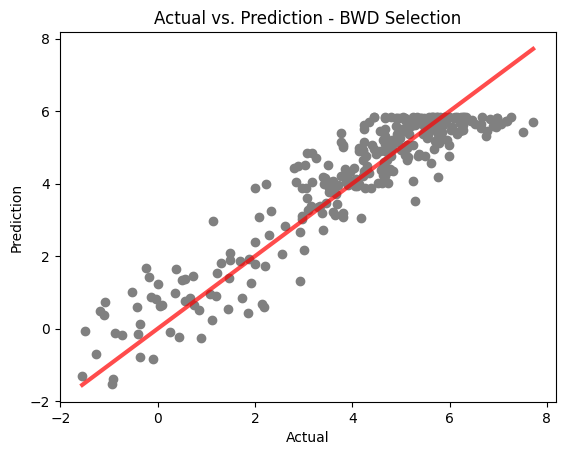

In [46]:
#Actual vs. Prediction
plt.scatter(x = test['y'], y = pred_bwd, c = 'gray')
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - BWD Selection')

#Add 45 degree line
xp = np.linspace(test['y'].min(), test['y'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .7)
plt.show()

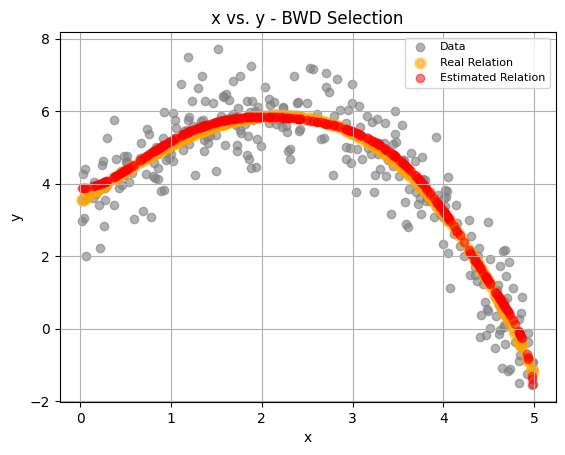

In [47]:
#Real relation btw x and y vs. estimated ones
plt.scatter(test['x'], test['y'], c = 'gray', alpha = .6, label = 'Data')
plt.scatter(test['x'], 3.5 + (1.8 * test['x']) - (0.15 * test['x'] ** 2) - (0.08 * test['x'] ** 3), c = 'orange', linewidth = 3,
         alpha = .5, label = 'Real Relation')
plt.scatter(test['x'], pred_bwd, c = 'red', alpha = .5, label = 'Estimated Relation')
plt.title('x vs. y - BWD Selection')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = '8')
plt.grid()

### Ridge Regression 

In [48]:
#Scale data before implementing Ridge regression
from sklearn.preprocessing import StandardScaler
x_train_scaled = StandardScaler().fit_transform(x_train)
x_train_scaled

array([[ 0.        , -1.7261126 , -1.11351738, ..., -0.49117418,
        -0.45984177, -0.43377672],
       [ 0.        , -1.72260584, -1.11351394, ..., -0.49117418,
        -0.45984177, -0.43377672],
       [ 0.        , -1.71909908, -1.11350361, ..., -0.49117418,
        -0.45984177, -0.43377672],
       ...,
       [ 0.        ,  1.76662069,  2.30000841, ...,  4.15997729,
         4.37356295,  4.57188503],
       [ 0.        ,  1.77363421,  2.31373111, ...,  4.23522181,
         4.46161855,  4.67331348],
       [ 0.        ,  1.77714097,  2.32060279, ...,  4.27324189,
         4.50617876,  4.72471809]])

In [49]:
#Implement Ridge regression - model 4
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 0.1) #lambda = 0.1 (regularization hyperparameter)
model_4 = ridge_reg.fit(x_train_scaled, trans_y_train)

In [50]:
#Grid
lambda_grid = 10 ** np.linspace(3, -3, 100)

In [51]:
#K-fold cross validation to choose the best model
from sklearn.model_selection import cross_val_score

cv_errors = np.zeros(shape = len(lambda_grid)) #to save cv results

for i in range(len(lambda_grid)):
    ridge_reg = Ridge(alpha = lambda_grid[i])
    scores = cross_val_score(estimator = ridge_reg, 
                             X = x_train_scaled, 
                             y = trans_y_train,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 5, n_jobs = -1)
    cv_errors[i] = scores.mean() 

In [52]:
#Best lambda
best_lamda = lambda_grid[np.argmax(cv_errors)]

In [53]:
#Best model coefs:
ridge_reg = Ridge(alpha = best_lamda)
model_4 = ridge_reg.fit(x_train_scaled, trans_y_train)

In [54]:
#Predict on test - model 4
#Sacle test data set
x_test_scaled = StandardScaler().fit_transform(x_test)
pred_ridge = model_4.predict(x_test_scaled)
pred_ridge = pd.Series(yeojohnson.inverse_transform(pred_ridge).reshape(-1), index = test.index)

In [55]:
#Absolute error
abs_err_ridge = abs(test['y'] - pred_ridge)

#Absolute error mean, median, sd, IQR, max, min
models_comp = pd.concat([models_comp, 
                         pd.DataFrame({'Mean of AbsErrors':    abs_err_ridge.mean(),
                                       'Median of AbsErrors' : abs_err_ridge.median(),
                                       'SD of AbsErrors' :     abs_err_ridge.std(),
                                       'IQR of AbsErrors':     iqr(abs_err_ridge),
                                       'Min of AbsErrors':     abs_err_ridge.min(),
                                       'Max of AbsErrors':     abs_err_ridge.max()}, 
                                      index = ['LM_Ridge'])])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
LM_t-test,0.994962,0.561788,1.888351,0.752861,0.000062,16.660633
LM_FWD,0.610102,0.479101,0.486081,0.645161,0.001382,2.168739
LM_BWD,0.604303,0.478332,0.480753,0.624961,0.002631,2.080370
LM_Ridge,0.748580,0.555280,0.638305,0.811578,0.002585,2.826946


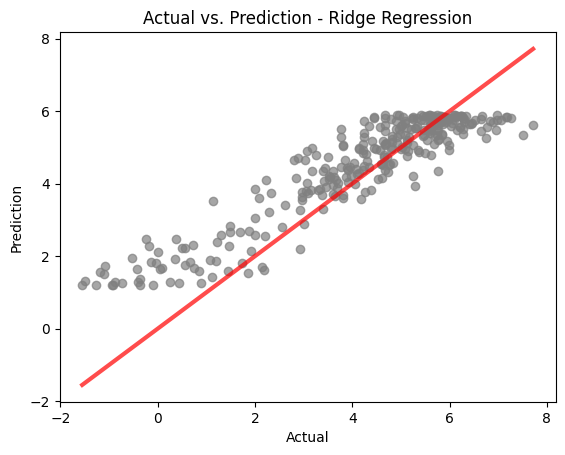

In [56]:
#Actual vs. Prediction
plt.scatter(x = test['y'], y = pred_ridge, c = 'gray', alpha = 0.7)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - Ridge Regression')

#Add 45 degree line
xp = np.linspace(test['y'].min(), test['y'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = .7)
plt.show()

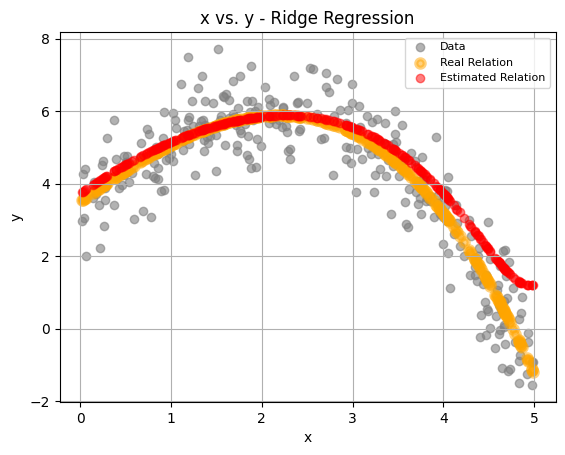

In [57]:
#Real relation btw x and y vs. estimated ones
plt.scatter(test['x'], test['y'], c = 'gray', alpha = .6, label = 'Data')
plt.scatter(test['x'], 3.5 + (1.8 * test['x']) - (0.15 * test['x'] ** 2) - (0.08 * test['x'] ** 3), c = 'orange', linewidth = 3,
         alpha = .5, label = 'Real Relation')
plt.scatter(test['x'], pred_ridge, c = 'red', alpha = .5, label = 'Estimated Relation')
plt.title('x vs. y - Ridge Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = '8')
plt.grid()

### LASSO Regression

In [58]:
#Implement LASSO regression - model 5
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1) #lambda = 0.1 (regularization hyperparameter)
model_5 = lasso_reg.fit(x_train_scaled, trans_y_train)

In [59]:
#K-fold cross validation to choose the best model

cv_errors = np.zeros(shape = len(lambda_grid)) #to save cv results

for i in range(len(lambda_grid)):
    lasso_reg = Lasso(alpha = lambda_grid[i])
    scores = cross_val_score(estimator = lasso_reg, 
                             X = x_train_scaled, 
                             y = trans_y_train,
                             scoring = 'neg_root_mean_squared_error',
                             cv = 5, n_jobs = -1)
    cv_errors[i] = scores.mean() 

In [60]:
#Best lambda
best_lamda = lambda_grid[np.argmax(cv_errors)]

In [61]:
#Best model coefs:
lasso_reg = Lasso(alpha = best_lamda)
model_5 = lasso_reg.fit(x_train_scaled, trans_y_train)

C:\Users\sayan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.888e-01, tolerance: 7.000e-02
  model = cd_fast.enet_coordinate_descent(


In [62]:
#Predict on test - model 5
pred_lasso = model_5.predict(x_test_scaled)
pred_lasso = pd.Series(yeojohnson.inverse_transform(pred_lasso.reshape(-1, 1)).reshape(-1), index = test.index)

In [63]:
#Absolute error
abs_err_lasso = abs(test['y'] - pred_lasso)

#Absolute error mean, median, sd, IQR, max, min
models_comp = pd.concat([models_comp, 
                         pd.DataFrame({'Mean of AbsErrors':    abs_err_lasso.mean(),
                                       'Median of AbsErrors' : abs_err_lasso.median(),
                                       'SD of AbsErrors' :     abs_err_lasso.std(),
                                       'IQR of AbsErrors':     iqr(abs_err_lasso),
                                       'Min of AbsErrors':     abs_err_lasso.min(),
                                       'Max of AbsErrors':     abs_err_lasso.max()}, 
                                      index = ['LM_LASSO'])])
models_comp

,Mean of AbsErrors,Median of AbsErrors,SD of AbsErrors,IQR of AbsErrors,Min of AbsErrors,Max of AbsErrors
LM_t-test,0.994962,0.561788,1.888351,0.752861,0.000062,16.660633
LM_FWD,0.610102,0.479101,0.486081,0.645161,0.001382,2.168739
LM_BWD,0.604303,0.478332,0.480753,0.624961,0.002631,2.080370
LM_Ridge,0.748580,0.555280,0.638305,0.811578,0.002585,2.826946
LM_LASSO,0.748497,0.555285,0.636208,0.812937,0.002348,2.849858


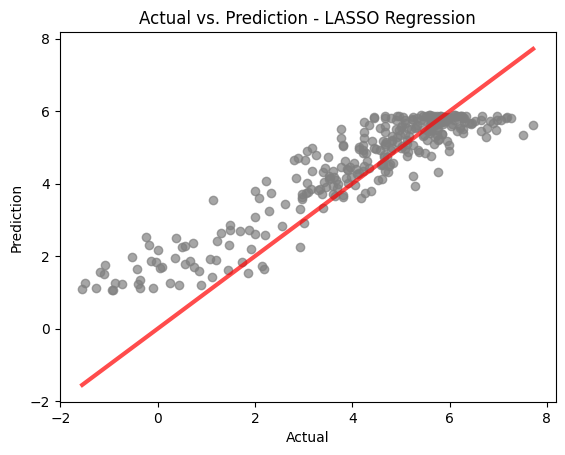

In [64]:
#Actual vs. Prediction
plt.scatter(x = test['y'], y = pred_lasso, c = 'gray', alpha = 0.7)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.title('Actual vs. Prediction - LASSO Regression')

#Add 45 degree line
xp = np.linspace(test['y'].min(), test['y'].max(), 100)
plt.plot(xp, xp, c = 'red', linewidth = 3, alpha = 0.7)
plt.show()

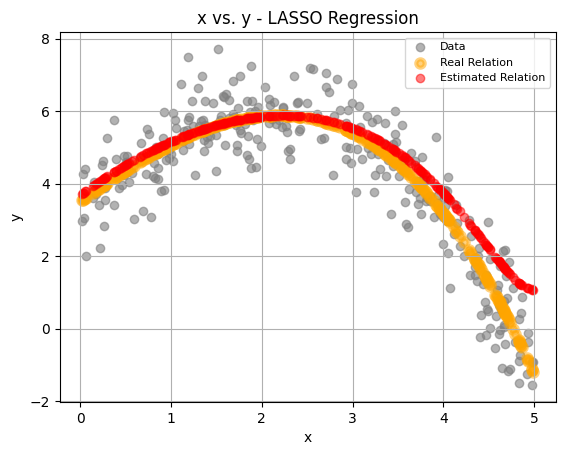

In [65]:
#Real relation btw x and y vs. estimated ones
plt.scatter(test['x'], test['y'], c = 'gray', alpha = .6, label = 'Data')
plt.scatter(test['x'], 3.5 + (1.8 * test['x']) - (0.15 * test['x'] ** 2) - (0.08 * test['x'] ** 3), c = 'orange', linewidth = 3,
         alpha = .5, label = 'Real Relation')
plt.scatter(test['x'], pred_lasso, c = 'red', alpha = .5, label = 'Estimated Relation')
plt.title('x vs. y - LASSO Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(fontsize = '8')
plt.grid()

### Conclusion 

The best model amoung all 5 models is model 4 - BWD